In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from utils.TD import TD_Adam, TD_SGD
from utils.NeuralNet import TwoLayerFCNN_Adam, TwoLayerFCNN_SGD

from utils import Benchmarking

seed = 42
torch.manual_seed(seed)

In [2]:
housedata = torch.tensor(np.loadtxt('data\\readyhousedata.txt', delimiter=','), dtype=torch.float32)

X = housedata[:, :-1]
y = housedata[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
# Parameters for TD
num_samples, num_features = X_train.shape
P = torch.ones((num_samples, num_samples)) / num_samples # Equal probability to move to any state

identity = lambda x : x
n_iter = 1e5
alpha = 0.01
epsilon = 1e-7

hidden_layers = 64
batch_size = 32
n_epochs = 100

In [4]:
# Initialise classes
td_sgd = TD_SGD(
    n_iter=n_iter,
    P=P,
    link=identity,
    inv_link=identity,
    gamma=0,
    alpha=alpha,
    epsilon=epsilon,
)

td_adam = TD_Adam(
    n_iter=n_iter,
    P=P,
    link=identity,
    inv_link=identity,
    gamma=0,
    alpha=alpha,
    epsilon=epsilon,
)

nn_sgd = TwoLayerFCNN_SGD(
    batch_size=batch_size,
    lr=alpha,
    n_epochs=n_epochs,
    input_size=num_features,
    hidden_size=hidden_layers,
)

nn_adam = TwoLayerFCNN_Adam(
    batch_size=batch_size,
    lr=alpha,
    n_epochs=n_epochs,
    input_size=num_features,
    hidden_size=hidden_layers,
)

In [5]:
# Train the TD models
td_sgd.fit(X_train, y_train)
td_adam.fit(X_train, y_train)

# Train the NN models
nn_sgd.fit(X_train, y_train)
nn_adam.fit(X_train, y_train)

Ending optimization early at iteration 30043
Ending optimization early at iteration 8482
Epoch [1/100], Loss: 204.2496
Epoch [2/100], Loss: 70.8366
Epoch [3/100], Loss: 63.9146
Epoch [4/100], Loss: 41.2357
Epoch [5/100], Loss: 37.3071
Epoch [6/100], Loss: 42.5998
Epoch [7/100], Loss: 34.1539
Epoch [8/100], Loss: 48.4272
Epoch [9/100], Loss: 28.4035
Epoch [10/100], Loss: 37.3736
Epoch [11/100], Loss: 26.5768
Epoch [12/100], Loss: 49.1628
Epoch [13/100], Loss: 41.5310
Epoch [14/100], Loss: 32.8206
Epoch [15/100], Loss: 29.1604
Epoch [16/100], Loss: 25.2735
Epoch [17/100], Loss: 26.5402
Epoch [18/100], Loss: 22.7395
Epoch [19/100], Loss: 22.2275
Epoch [20/100], Loss: 24.4956
Epoch [21/100], Loss: 29.4318
Epoch [22/100], Loss: 26.8563
Epoch [23/100], Loss: 23.3673
Epoch [24/100], Loss: 22.8749
Epoch [25/100], Loss: 34.5776
Epoch [26/100], Loss: 21.9637
Epoch [27/100], Loss: 23.5303
Epoch [28/100], Loss: 22.6743
Epoch [29/100], Loss: 23.7048
Epoch [30/100], Loss: 20.8326
Epoch [31/100], Los

In [6]:
# Define noise standard deviation
noise_std = 0.1

# Add Gaussian noise to the test set
X_test_noisy = X_test + torch.randn(X_test.shape) * noise_std

In [7]:
# TD predictions on original and noisy test sets
y_pred_td_sgd = td_sgd.predict(X_test)
y_pred_td_sgd_noisy = td_sgd.predict(X_test_noisy)

y_pred_td_adam = td_adam.predict(X_test)
y_pred_td_adam_noisy = td_adam.predict(X_test_noisy)

# NN predictions on original and noisy test sets
y_pred_nn_sgd = nn_sgd.predict(X_test)
y_pred_nn_sgd_noisy = nn_sgd.predict(X_test_noisy)

y_pred_nn_adam = nn_adam.predict(X_test)
y_pred_nn_adam_noisy = nn_adam.predict(X_test_noisy)

In [8]:
# Measure the average change in output values for all methods
change_td_sgd = Benchmarking.mean_absolute_diff(y_pred_td_sgd, y_pred_td_sgd_noisy)
change_td_adam = Benchmarking.mean_absolute_diff(y_pred_td_adam, y_pred_td_adam_noisy)
change_nn_sgd = Benchmarking.mean_absolute_diff(y_pred_nn_sgd, y_pred_nn_sgd_noisy)
change_nn_adam = Benchmarking.mean_absolute_diff(y_pred_nn_adam, y_pred_nn_adam_noisy)

# Print the results
print(f"Average change for TD-SGD: {change_td_sgd}")
print(f"Average change for TD-Adam: {change_td_adam}")
print(f"Average change for NN-SGD: {change_nn_sgd}")
print(f"Average change for NN-Adam: {change_nn_adam}")

Average change for TD-SGD: 2.973118543624878
Average change for TD-Adam: 2.179767370223999
Average change for NN-SGD: 3.33113694190979
Average change for NN-Adam: 3.408379316329956


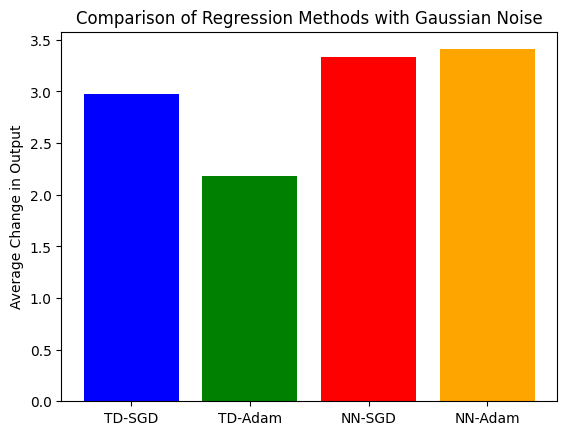

In [9]:
# Plot the changes in predictions
Benchmarking.plot_noise_diff(
    td_sgd=change_td_sgd, 
    td_adam=change_td_adam, 
    nn_sgd=change_nn_sgd, 
    nn_adam=change_nn_adam,
    )